# Imitation learning
The notebook contains an agent that learns from a simple hand-designed agent.
First, we train a simple agent that moves towards the apple deterministically (copied from agents.py):

```
def simple_agent(state):
    y_player, x_player = max_idx(state[0,:,:])
    y_apple, x_apple = max_idx(state[1,:,:])

    if y_player < y_apple:
        return "down"
    elif y_player > y_apple:
        return "up"
    elif x_player < x_apple:
        return "right"
    elif x_player > x_apple:
        return "left"
    else:
        return "up"
````

Then, after training over 6000 games, a deep cnn model successfully manage to mimic this behaviour and receiving the same amount of average reward.

In [1]:
import snakai
import agents
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import datetime



In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','ended'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory(10000)

## Collect Data

In [3]:
def play_game(snake, agent, epsilon = 0.05):
    cum_reward = 0.0
    snake.on_init()
    state, reward, ended = snake.on_feedback()

    for i in range(200):
        action = agent(state, th = epsilon)
        next_state, reward, ended = snake.step(action)
        cum_reward += float(reward)
        
        # Only keep the games that gave results:
        if reward >= 0:
            memory.push(state, action, next_state, reward, ended)
        state = next_state
        if ended == 1:
            return cum_reward, i
    return cum_reward, i


In [4]:
game_size = (10, 10)
steps = 1000
snake = snakai.Snake(render=False, 
                     game_size = game_size, 
                     time_reward = 0.01)
snake.on_init()

avg_reward = np.zeros(steps)
for i in range(steps):
    reward, _ = play_game(snake, lambda state, th: agents.simple_agent(state))
    avg_reward[i] = reward
    
np.mean(avg_reward)

4.372099999999997

## Define model

In [6]:
def tuple_to_torch(tup):
    return torch.from_numpy(np.array(tup))

action2ind = {'right' : 0,
             'left' : 1,
             'up' : 2,
             'down' : 3}
ind2action = {val: key for key, val in action2ind.items()}


In [7]:
ch = 64
ksize = 4
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, ch, kernel_size=ksize, stride=2, padding = 2)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, kernel_size=ksize, stride=1, padding = 1)
        self.conv3 = nn.Conv2d(ch, ch, kernel_size=ksize, stride=1, padding = 0)
        #self.dense1 = nn.Linear(2592, 1024)
        self.head = nn.Linear(256, 4)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.dense1(x))
        return (self.head(x))
    
model = DQN()

In [39]:
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.001)


In [40]:
# fetch and concat batch:
def train_batch():
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    state_batch = Variable(tuple_to_torch(batch.state))
    action_batch = Variable(tuple_to_torch(list(action2ind[a] for a in batch.action)))
    reward_batch = Variable(tuple_to_torch(batch.reward))

    yhat = model(state_batch.float())

    loss = nn.CrossEntropyLoss()(yhat, action_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

## Train

In [46]:
snake = snakai.Snake(render=False, 
                     game_size = game_size, 
                     time_reward = 0.01)
snake.on_init()


steps = 1000
L = np.zeros(steps)
for i in range(steps):
    L[i] = float(train_batch())
    for _ in range(5):
        play_game(snake, lambda state, th: agents.simple_agent(state))

### Results (latest epochs first)

0.048304110744502395

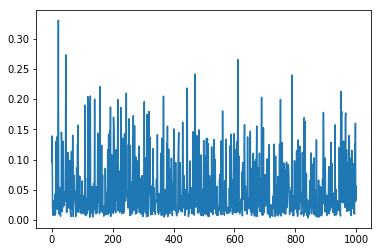

In [47]:
plt.plot(L)
np.mean(L)

0.047089667725143954

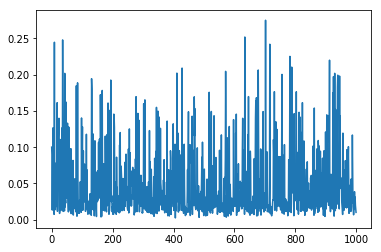

In [42]:
plt.plot(L)
np.mean(L)

0.0849888928681612

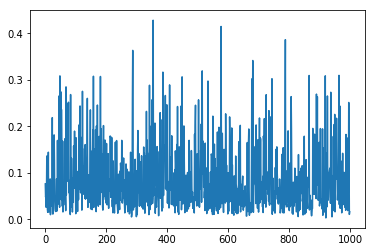

In [38]:
plt.plot(L)
np.mean(L)

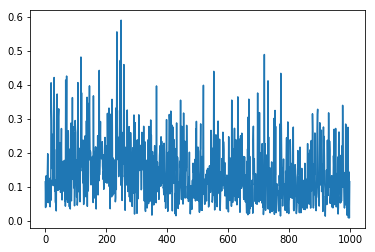

In [24]:
plt.plot(L)

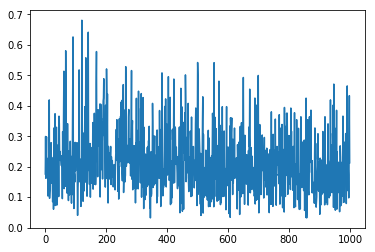

In [18]:
plt.plot(L)

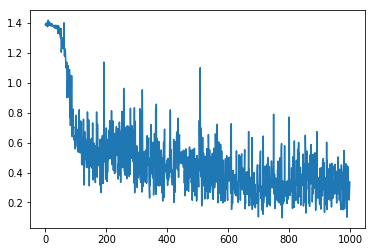

In [11]:
plt.plot(L)

## Test policy

In [48]:
def deep_policy(state, th):
    if random.random() < th:
        return ind2action[random.randint(0,3)]
    yhat = model(Variable(torch.unsqueeze(torch.from_numpy(state),0).float()))
    pred_action = ind2action[int(yhat.max(1)[1])]
    return pred_action

In [49]:
steps = 500
snake = snakai.Snake(render=False, 
                     game_size = game_size, 
                     time_reward = 0.0)

avg_reward = np.zeros(steps)
for i in range(steps):
    reward, _ = play_game(snake, deep_policy, epsilon=0.0)
    avg_reward[i] = reward
    
np.mean(avg_reward)

4.364

In [52]:
snake = snakai.Snake(render=True, 
                     game_size = game_size, 
                     time_reward = 0.0)
snake.on_init()
state, reward, done = snake.on_feedback()

for _ in range(5):
    print(play_game(snake, deep_policy))

(3.0, 36)
(1.0, 15)
(-1.0, 1)
(0.0, 8)
(11.0, 71)
